##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Super Resolution using ESRGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_enhancing"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

**Preparing Environment**

In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"



    import os: This statement imports the os module, which provides a way to interact with the operating system. It is commonly used for tasks such as file and directory operations.

    import time: This statement imports the time module, which provides various functions related to time, such as measuring time intervals or pausing the execution of a program.

    from PIL import Image: This statement imports the Image module from the PIL (Python Imaging Library) package. PIL is a library for opening, manipulating, and saving many different image file formats.

    import numpy as np: This statement imports the numpy module and assigns it the alias np. Numpy is a powerful numerical computing library in Python that provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.

    import tensorflow as tf: This statement imports the tensorflow module, which is a popular open-source machine learning framework. TensorFlow provides a variety of tools and libraries for building and training machine learning models.

    import tensorflow_hub as hub: This statement imports the tensorflow_hub module and assigns it the alias hub. TensorFlow Hub is a library that provides a repository of pre-trained machine learning models, which can be easily integrated into TensorFlow-based projects.

    import matplotlib.pyplot as plt: This statement imports the pyplot module from the matplotlib package and assigns it the alias plt. Matplotlib is a plotting library in Python widely used for creating visualizations and graphs.

    os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True": This line sets an environment variable called TFHUB_DOWNLOAD_PROGRESS to the value "True". The purpose of this specific variable is to enable download progress reporting when using TensorFlow Hub to download and cache models.


In [54]:
!wget "https://i.imgur.com/nZLOgy7.jpg" -O original.jpg

--2024-02-03 02:49:19--  https://i.imgur.com/nZLOgy7.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.52.193
Connecting to i.imgur.com (i.imgur.com)|151.101.52.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5811 (5.7K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>]   5.67K  --.-KB/s    in 0s      

2024-02-03 02:49:19 (69.1 MB/s) - ‘original.jpg’ saved [5811/5811]





    !: In a Jupyter notebook, the exclamation mark ! is used to indicate that the following command is a shell command, rather than a Python code statement.

    wget: wget is a command-line utility used for downloading files from the web. It is commonly used in Unix-like systems, including Linux.

    "https://i.imgur.com/nZLOgy7.jpg": This is the URL of the image file that we want to download. In this case, the image is hosted on Imgur and the URL points to the image file.

    -O original.png: This is an option used with the wget command to specify the output file name. In this case, the downloaded image file will be saved with the name original.png.
    Note that this link can be ended in png or jpg, for me, I turn the jpg image to jpg via the imgur https://h0339637.imgur.com/all, you can use png and upsample your own photo.


In [55]:
# Declaring Constants
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [56]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [57]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [58]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


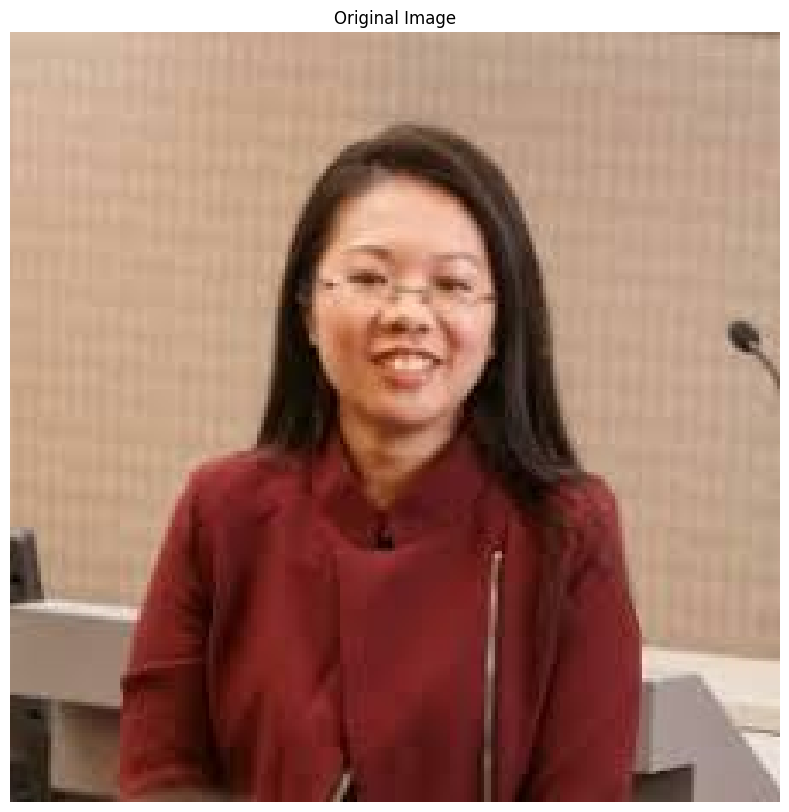

In [59]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [60]:
model = hub.load(SAVED_MODEL_PATH)

In [61]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 12.792546


Saved as Super Resolution.jpg


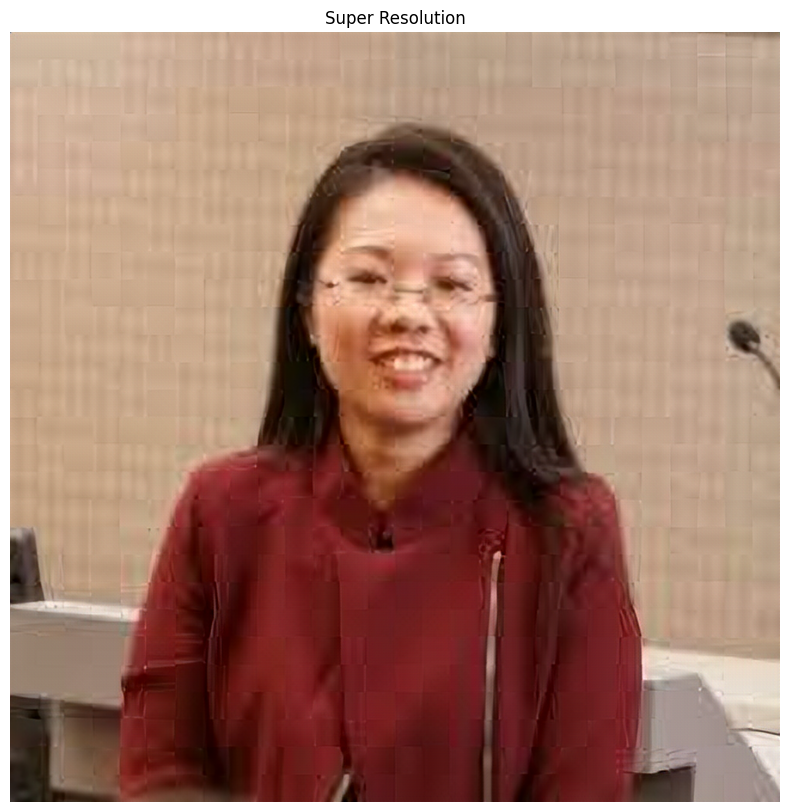

In [62]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

### Evaluating Performance of the Model

In [67]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

--2024-02-03 02:50:53--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 74.125.139.132, 2607:f8b0:400c:c05::84
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|74.125.139.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84897 (83K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  82.91K  --.-KB/s    in 0.001s  

2024-02-03 02:50:54 (134 MB/s) - ‘test.jpg’ saved [84897/84897]





    !: The exclamation mark ! indicates that the following command is a shell command.

    wget: wget is a command-line utility used for downloading files from the web.

    "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64": This is the URL of the image file that we want to download. It points to a specific image hosted on Google's user content service.

    -O test.jpg: This is an option used with the wget command to specify the output file name. In this case, the downloaded image file will be saved as test.jpg.

So, when this command is executed, it will download the image file from the provided URL and save it as test.jpg in the current directory.

The line IMAGE_PATH = "test.jpg" is a Python code statement that assigns the string value "test.jpg" to the variable IMAGE_PATH. This variable can be used later in the code to refer to the path of the downloaded image file.

In [64]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image



    The function is defined with the parameter image, which is expected to be a 3D or 4D tensor representing a preprocessed image.

    image_size is initialized as an empty list.

    The code checks the shape of the input image using len(image.shape). If the shape has three dimensions, it means the image is in the format [height, width, channels]. In this case, the dimensions of the image are extracted and assigned to image_size as [width, height]. If the shape has a different number of dimensions, a ValueError is raised, indicating that the function can only work on a single image.

    The image tensor is squeezed using tf.squeeze to remove any dimensions with size 1. This is done to ensure that the image tensor has a shape of [height, width, channels] if it was originally a 4D tensor.

    The image tensor is cast to tf.uint8 using tf.cast to ensure that its values are within the range of 0 to 255.

    The image tensor is then passed to Image.fromarray to create a PIL Image object. numpy() is called on the image tensor to convert it to a NumPy array before passing it to Image.fromarray.

    The PIL Image object is resized using bicubic interpolation to a new size of [image_size[0] // 4, image_size[1] // 4]. This downscales the image by a factor of 4 in both width and height.

    The downscaled image is converted back to a NumPy array using np.asarray.

    lr_image is expanded to have an additional dimension at the beginning using tf.expand_dims. This is done to make the shape of lr_image compatible with the original image tensor.

    lr_image is cast to tf.float32 using tf.cast to ensure that its values are represented as floating-point numbers.

    The downscaled image tensor lr_image is returned as the output of the function.


In [65]:
hr_image = preprocess_image(IMAGE_PATH)

The code hr_image = preprocess_image(IMAGE_PATH) is assigning the result of a function call to the variable hr_image. Let's break it down:

    preprocess_image is a function that takes an argument IMAGE_PATH. It is assumed that this function is defined elsewhere in the code.

    IMAGE_PATH is a variable that holds the path to an image file. It is assumed to be a string representing the file path.

    preprocess_image(IMAGE_PATH) is a function call, where the IMAGE_PATH variable is passed as an argument.

    The function call preprocess_image(IMAGE_PATH) performs some preprocessing on the image specified by the IMAGE_PATH variable. The exact details of the preprocessing steps would depend on the implementation of the preprocess_image function.

    The result of the function call, which is the preprocessed image, is assigned to the variable hr_image. The name "hr_image" suggests that it represents a high-resolution version of the image.


In [68]:
lr_image = downscale_image(tf.squeeze(hr_image))

The code lr_image = downscale_image(tf.squeeze(hr_image)) is assigning the result of a function call to the variable lr_image. Let's break it down:

    downscale_image is a function that takes an argument image. It is assumed that this function is defined elsewhere in the code.

    hr_image is a variable that holds an image tensor. It is assumed to be a high-resolution image tensor.

    tf.squeeze(hr_image) is calling the TensorFlow function tf.squeeze() on the hr_image tensor. This function removes any dimensions with size 1 from the tensor. It is used here to ensure that the image tensor has a shape of [height, width, channels] if it originally had additional dimensions.

    The result of tf.squeeze(hr_image) is passed as an argument to the downscale_image function.

    The downscale_image function applies bicubic downsampling to the input image tensor, scaling it down by a factor of 4 in both width and height.

    The result of the downscale_image function call, which is the downsampled image tensor, is assigned to the variable lr_image. The name "lr_image" suggests that it represents a low-resolution version of the image.

In summary, this code line calls the downscale_image function with the high-resolution image tensor hr_image (after removing any dimensions with size 1), and assigns the resulting low-resolution image tensor to the lr_image variable.

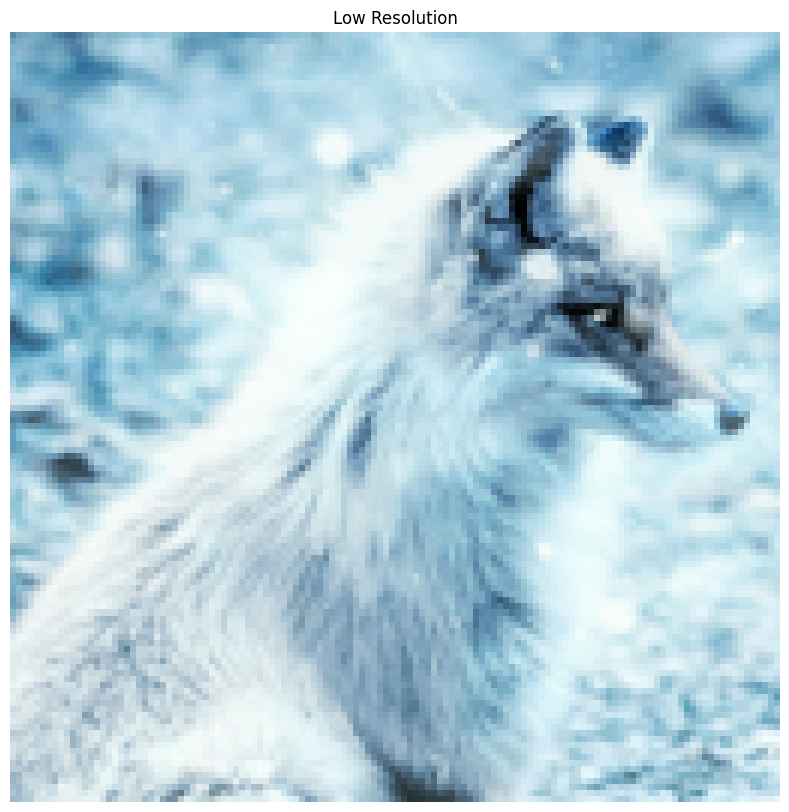

In [51]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [34]:
model = hub.load(SAVED_MODEL_PATH)

In [35]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 4.876820


PSNR Achieved: 28.029171


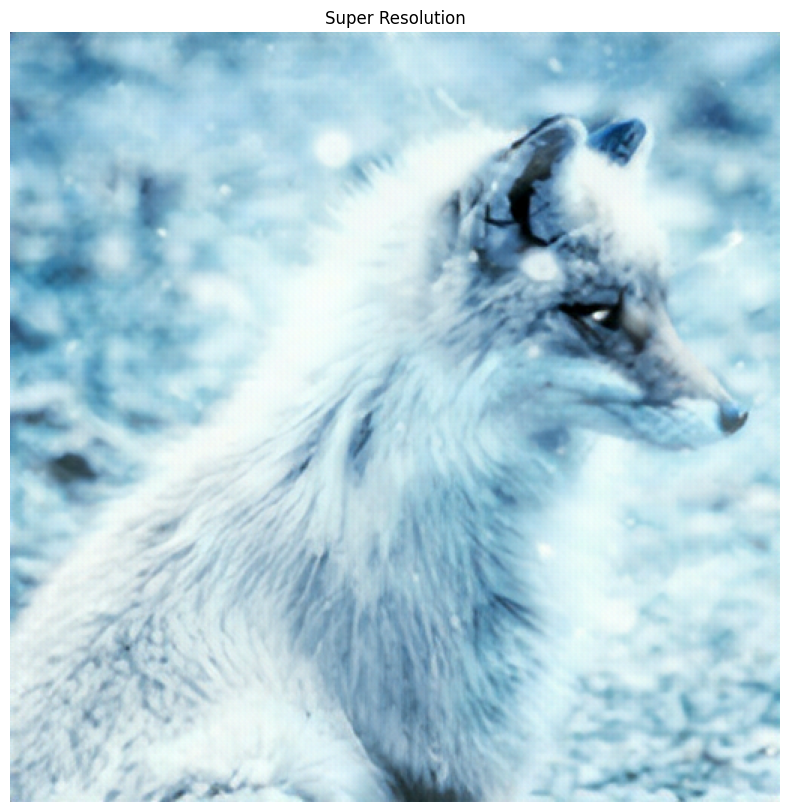

In [36]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

**Comparing Outputs size by side.**

PSNR: 28.029171


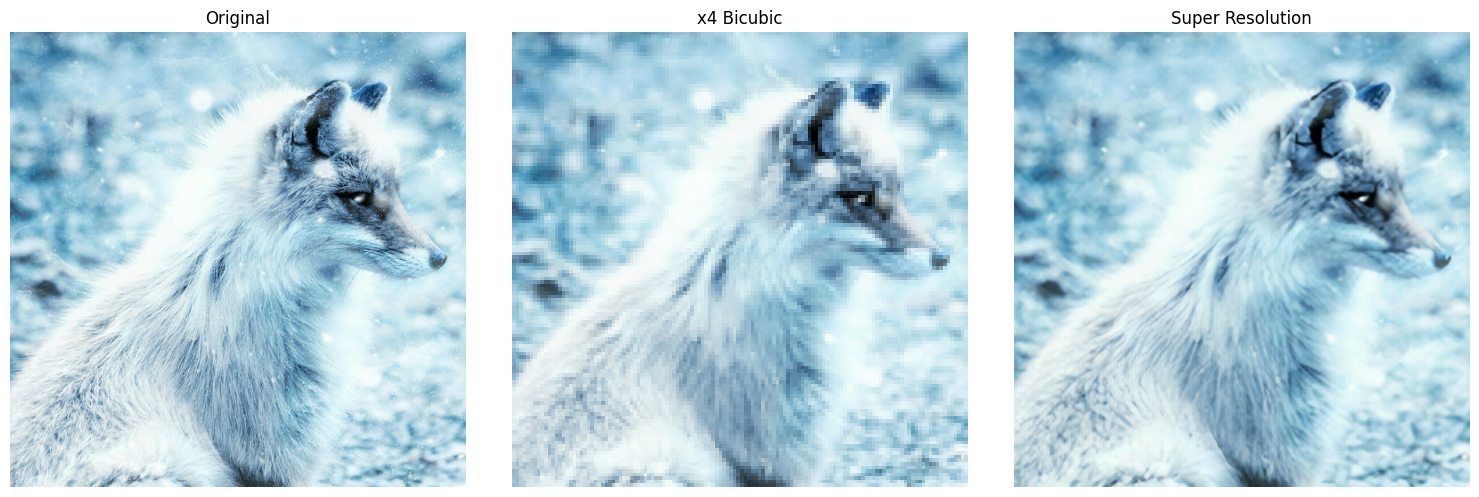

In [19]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)